In [4]:
import requests

market = "BTCUSDT"
tick_interval = "1h"

url = f"https://api.binance.com/api/v3/klines?symbol={market}&interval={tick_interval}"
data = requests.get(url).json()


In [5]:
from binance.client import Client
import pandas as pd
from datetime import timedelta, datetime

client = Client()
from_date = datetime.now() - timedelta(days=600)
candles = client.get_historical_klines(
    symbol="BTCUSDT",
    interval=Client.KLINE_INTERVAL_1DAY,
    start_str=from_date.isoformat(),
)

cd = pd.DataFrame(
    candles,
    columns=[
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Close time",
        "Quote asset volume",
        "Number of trades",
        "Taker buy base asset volume",
        "Taker buy quote asset volume",
        "Can be ignored",
    ],
    dtype=float,
)

for i in cd.index:
    cd.at[i, "Date"] = datetime.fromtimestamp(cd.at[i, "Date"] / 1000)

cd.index = pd.DatetimeIndex(cd["Date"])
cd.head(3)


,Date,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
Date,,,,,,,,,,,,
2020-09-14 02:00:00,2020-09-14 02:00:00,10332.84,10750.00,10212.34,10671.77,67059.291361,1.600128e+12,7.061756e+08,828957.0,31880.363157,3.357190e+08,0.0
2020-09-15 02:00:00,2020-09-15 02:00:00,10671.77,10930.04,10606.48,10785.31,61822.452786,1.600214e+12,6.664572e+08,893852.0,29744.087277,3.206402e+08,0.0
2020-09-16 02:00:00,2020-09-16 02:00:00,10785.23,11093.00,10661.22,10954.01,64991.512440,1.600301e+12,7.086450e+08,884153.0,31740.511691,3.461177e+08,0.0


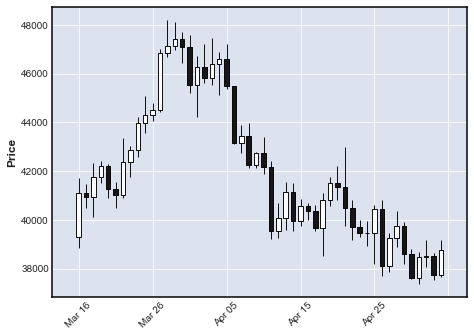

In [3]:
import mplfinance as mpf
from datetime import datetime

chart_data = cd[["Date", "Open", "High", "Low", "Close", "Volume"]]

mpf.plot(chart_data.tail(50), type="candle")


In [6]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting.test import SMA


class SmaCross(SignalStrategy, TrailingStrategy):
    n1 = 20
    n2 = 50

    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()

        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)

        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * 0.95

        # Set order entry sizes using the method provided by
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)

        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)


from backtesting import Backtest
from backtesting.test import GOOG

bt = Backtest(chart_data, SmaCross, cash=100000, commission=0.002)

bt.run()
bt.plot(filename="../src/results/SmaCross")


/var/folders/21/zw56sbb97yj_qzkf5yzv48lh0000gn/T/ipykernel_62820/2277031516.py:42: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename="../src/results/SmaCross")


Row(id='3886', ...)

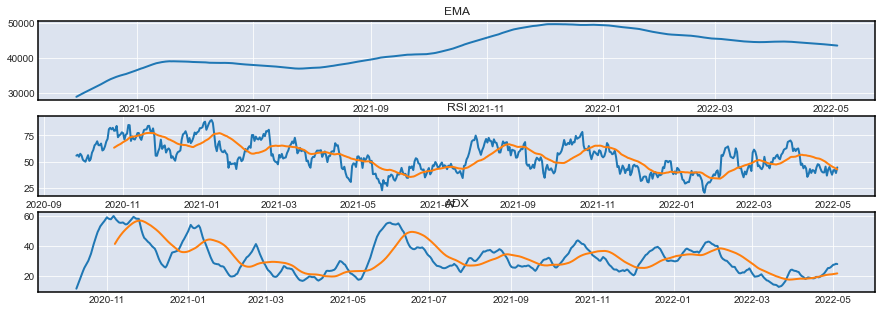

In [43]:
from talib import ADX, RSI, EMA, SMA
import matplotlib.pyplot as plt

rsi = RSI(chart_data["Close"])
rsiMA = SMA(rsi)

adx = ADX(chart_data["High"], chart_data["Low"], chart_data["Close"])
adxMA = SMA(adx)

ema = EMA(chart_data["Close"], timeperiod=200)

figure, axis = plt.subplots(3, 1, figsize=(15, 5))

axis[0].set_title("EMA")
axis[0].plot(ema)

axis[1].set_title("RSI")
axis[1].plot(rsi)
axis[1].plot(rsiMA)

axis[2].set_title("ADX")
axis[2].plot(adx)
axis[2].plot(adxMA)


# plt.figure(figsize=(15,5))
# plt.title('RSI')
# plt.plot(rsi)

# plt.title('ADX')
# plt.plot(adx)


In [42]:
indicatorsDF = pd.DataFrame(rsi, columns=["rsi"])
emaDF = pd.DataFrame(ema, columns=["ema"])
adxDF = pd.DataFrame(adx, columns=["adx"])
indicatorsDF.merge(adxDF, right_index=True, left_index=True).merge(
    emaDF, right_index=True, left_index=True
)


,rsi,adx,ema
2020-09-12 02:00:00,NaN,NaN,NaN
2020-09-13 02:00:00,NaN,NaN,NaN
2020-09-14 02:00:00,NaN,NaN,NaN
2020-09-15 02:00:00,NaN,NaN,NaN
2020-09-16 02:00:00,NaN,NaN,NaN
...,...,...,...
2022-04-30 02:00:00,37.434406,26.629618,43746.289770
2022-05-01 02:00:00,41.680632,27.482466,43693.772956
2022-05-02 02:00:00,41.968326,27.651542,43642.343972
2022-05-03 02:00:00,39.060030,28.151750,43583.504231


In [2]:
import ccxt

exchange = ccxt.binanceus({})
bars = exchange.fetch_ohlcv("ETH/USDT", timeframe="1m", limit=400)
print(bars)


[[1651848960000, 2696.26, 2698.48, 2694.15, 2694.15, 4.11542], [1651849020000, 2698.83, 2699.46, 2698.83, 2699.46, 0.08043], [1651849080000, 2700.1, 2701.27, 2700.1, 2700.57, 2.36122], [1651849140000, 2701.75, 2704.71, 2696.98, 2696.98, 3.16186], [1651849200000, 2696.46, 2696.46, 2695.9, 2695.9, 1.63662], [1651849260000, 2701.94, 2701.94, 2701.94, 2701.94, 0.30867], [1651849320000, 2696.5, 2696.82, 2694.51, 2696.82, 1.97623], [1651849380000, 2690.61, 2690.61, 2689.97, 2689.97, 0.23724], [1651849440000, 2697.24, 2697.24, 2697.24, 2697.24, 0.00924], [1651849500000, 2696.0, 2702.59, 2695.84, 2701.42, 15.00373], [1651849560000, 2699.71, 2699.71, 2699.0, 2699.0, 7.67595], [1651849620000, 2698.52, 2699.56, 2698.52, 2699.56, 0.17266], [1651849680000, 2704.52, 2709.41, 2704.52, 2709.41, 1.88195], [1651849740000, 2708.51, 2710.84, 2708.03, 2710.84, 5.24198], [1651849800000, 2704.4, 2704.4, 2699.94, 2700.89, 2.69446], [1651849860000, 2700.66, 2701.51, 2699.94, 2701.51, 0.43793], [1651849920000, 